# Changing Cuts

---

Aditya Marathe

In [7]:
%matplotlib inline

import os
import sys

import dotenv

import pathlib

import h5py

import pandas as pd

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Local imports
sys.path.insert(1, './../')

from initial_analysis import *
from utils import *
from cuts import Cuts

In [57]:
from ipywidgets import widgets
from ipywidgets import interact

In [2]:
# The '.env' file contains the directory to the data.
dotenv.load_dotenv();

In [3]:
file_dir = pathlib.Path(os.environ[LocalDatasets.REALLY_MINI])

df = load_nova_sample(file_dir)

In [4]:
numu_cuts = Cuts.init_nova_cuts()

In [5]:
def efficiency(
        cut_signal_events: int,
        sample_signal_events: int
    ) -> float:
    return cut_signal_events / sample_signal_events

In [40]:
# Redefine the PID cuts
def numu_2020_pid_cut(
        df: pd.DataFrame, 
        remid_threshold: float = 0.3,
        numuid_threshold: float = 0.8
    ) -> pd.Series:
    a = df['rec.sel.remid.pid'] > remid_threshold
    b = df['rec.sel.cvnloosepreselptp.numuid'] > numuid_threshold
    return a & b

In [41]:
def plot(
        axs: list[Axes], 
        axs_index: int, 
        df: pd.DataFrame, 
        new_numuid_threshold: float = 0.3, 
        new_remid_threshold: float = 0.8
    ) -> None:    
    plot_info = draw_plot_info(axs[axs_index])

    numu_cuts.define_cut(
        name='CVN PID Score', 
        cut_func=lambda df: numu_2020_pid_cut(
            df=df,
            remid_threshold=new_remid_threshold,
            numuid_threshold=new_numuid_threshold
        )
    )
    df_numu_cuts = numu_cuts.apply_all_cuts(df=df)

    bins_conf = np.linspace(0, 5, 50 + 1)

    *_, bc = axs[axs_index].hist(
        df_numu_cuts['rec.energy.numu.lstmnu'], 
        bins=bins_conf, 
        label='Passed Cuts',
        alpha=0.6
    )
    plot_info(df_numu_cuts['rec.energy.numu.lstmnu'], bc, 'Passed Cuts')

    *_, bc = axs[axs_index].hist(
        df_numu_cuts['rec.energy.numu.lstmnu'][~df_numu_cuts['isNuMuCC']], 
        bins=bins_conf,
        label='Background',
        alpha=0.6
    )
    plot_info(df_numu_cuts['rec.energy.numu.lstmnu'][~df_numu_cuts['isNuMuCC']], bc, 'Background')

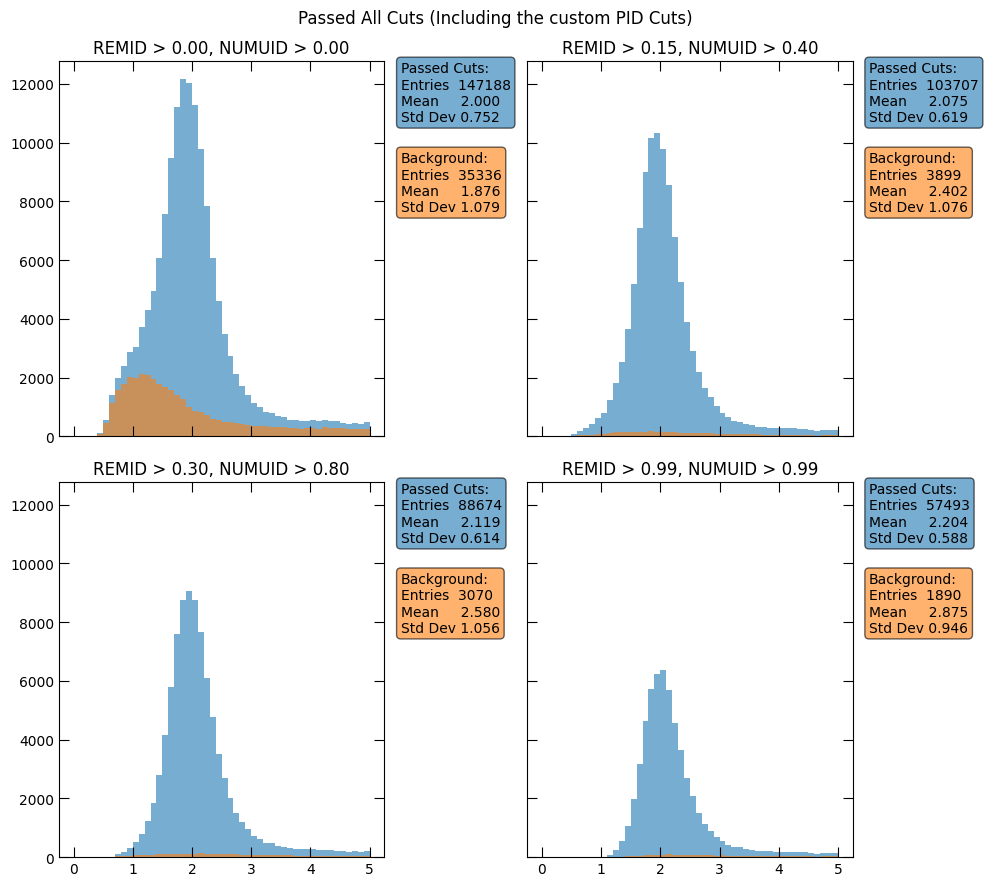

In [42]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 9))

axs = axs.flatten()

plot(
    axs=axs,
    axs_index=0,
    df=df,
    new_remid_threshold=0,
    new_numuid_threshold=0
)
axs[0].set_title('REMID > 0.00, NUMUID > 0.00')

#

plot(
    axs=axs,
    axs_index=1,
    df=df,
    new_remid_threshold=0.15,
    new_numuid_threshold=0.4
)
axs[1].set_title('REMID > 0.15, NUMUID > 0.40')

# 

plot(
    axs=axs,
    axs_index=2,
    df=df
)
axs[2].set_title('REMID > 0.30, NUMUID > 0.80')

#

plot(
    axs=axs,
    axs_index=3,
    df=df,
    new_remid_threshold=0.99,
    new_numuid_threshold=0.99
)
axs[3].set_title('REMID > 0.99, NUMUID > 0.99')

for ax in axs:
    ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)

fig.suptitle('Passed All Cuts (Including the custom PID Cuts)')

plt.tight_layout();

In [48]:
id_values = np.linspace(0, 1., 15)

result = np.zeros((id_values.shape[0], id_values.shape[0]))

# Not the most efficient way to do this, but it works
for i, numuid in enumerate(id_values):
    for j, remid in enumerate(id_values):
        numu_cuts.define_cut(
            name='CVN PID Score', 
            cut_func=lambda df: numu_2020_pid_cut(
                df=df,
                remid_threshold=remid,
                numuid_threshold=numuid
            )
        )
        df_numu_cuts = numu_cuts.apply_all_cuts(df=df)

        # Number of signal events
        sig = len(df_numu_cuts['rec.energy.numu.lstmnu'][df_numu_cuts['isNuMuCC']])
        # Total number of signal events
        total_sig = len(df[df['isNuMuCC']])

        try:
            result[j, i] = efficiency(
                cut_signal_events=sig,
                sample_signal_events=total_sig
            )
        except ZeroDivisionError:
            result[j, i] = 0.

$$
    \text{Efficiency} = \frac{\text{Signal Events Post-Cuts}}{\text{Total Signal Events}}
$$


In [50]:
print(f'Max(Efficiency) = {np.max(result):0.2f}%')

Max(Efficiency) = 0.43%


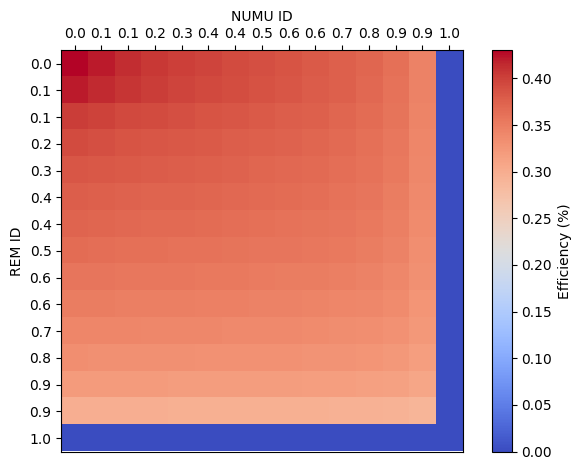

In [54]:
fig, ax = plt.subplots()

imshow = ax.imshow(result, cmap='coolwarm')

plt.colorbar(imshow, ax=ax, label=r'Efficiency (%)')

ax.set_xticks(range(result.shape[0]), np.round(id_values, 1))
ax.set_yticks(range(result.shape[1]), np.round(id_values, 1))

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xlabel('NUMU ID')
ax.set_ylabel('REM ID')

plt.tight_layout();

In [68]:
@widgets.interact(
        n_cropped_events=(1_000, 50_000, 1_000),
        remid_cut=(0, 1, 0.05),
        numuid_cut=(0, 1, 0.05)
)
def interactive_plot(
        n_cropped_events: int = 30_000,
        remid_cut: float = 0.3, 
        numuid_cut: float = 0.8
    ) -> None:

    fig, ax = plt.subplots()

    ax.plot(
        df['rec.sel.cvnloosepreselptp.numuid'][~df['isNuMuCC']][:n_cropped_events],
        df['rec.sel.remid.pid'][~df['isNuMuCC']][:n_cropped_events],
        'o',
        alpha=0.6,
        label='Background'
    )

    ax.plot(
        df['rec.sel.cvnloosepreselptp.numuid'][df['isNuMuCC']][:n_cropped_events],
        df['rec.sel.remid.pid'][df['isNuMuCC']][:n_cropped_events],
        'o',
        alpha=0.6,
        label='Signal'
    )

    ax.axvline(numuid_cut, color='r', linestyle='--', label=r'$\nu_\mu$ ID Cut')
    ax.axhline(remid_cut, color='b', linestyle='--', label='REM ID Cut')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_xlabel(r'$\nu_\mu$ ID')
    ax.set_ylabel(r'REM ID')

    ax.legend()

    plt.tight_layout();

interactive(children=(IntSlider(value=30000, description='n_cropped_events', max=50000, min=1000, step=1000), …